# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

2021-09-25 05:03:08.345829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Importing Image Directory

In [2]:
training_images=os.listdir('../input/pins-face-recognition/105_classes_pins_dataset/pins_jeff bezos/')

# Creating image set and appending into the list

In [3]:
create_train_set=[]
for i in training_images:
    img = image.load_img('../input/pins-face-recognition/105_classes_pins_dataset/pins_jeff bezos/'+i,target_size=(64,64,3),color_mode= 'rgb',interpolation='nearest')
    img=image.img_to_array(img)
    img=img/255
    create_train_set.append(img)
training_set=np.array(create_train_set)                   
                   
                   

# Function to show image

In [4]:
def show_img(dataset):
    fig, ax = plt.subplots(1,4)
    fig.set_size_inches(40, 20)
    for i in range(4,8):
        ax[i-4].imshow(dataset[i].reshape(64,64,3))
    plt.show()

# Function to add guassian noise/Corrupting image pixels

In [5]:
def blur(a):
    kernel = np.array([[1.0,2.0,1.0], [2.0,4.0,2.0], [1.0,2.0,1.0]])
    kernel = kernel / np.sum(kernel)
    arraylist = []
    for y in range(3):
        temparray = np.copy(a)
        temparray = np.roll(temparray, y - 1, axis=0)
        for x in range(3):
            temparray_X = np.copy(temparray)
            temparray_X = np.roll(temparray_X, x - 1, axis=1)*kernel[y,x]
            arraylist.append(temparray_X)

    arraylist = np.array(arraylist)
    arraylist_sum = np.sum(arraylist, axis=0)
    return arraylist_sum
     

In [6]:
blurred_dataset=blur(training_set)

In [7]:
blurred_dataset=np.array(blurred_dataset)

# Visualizing the corrupted image

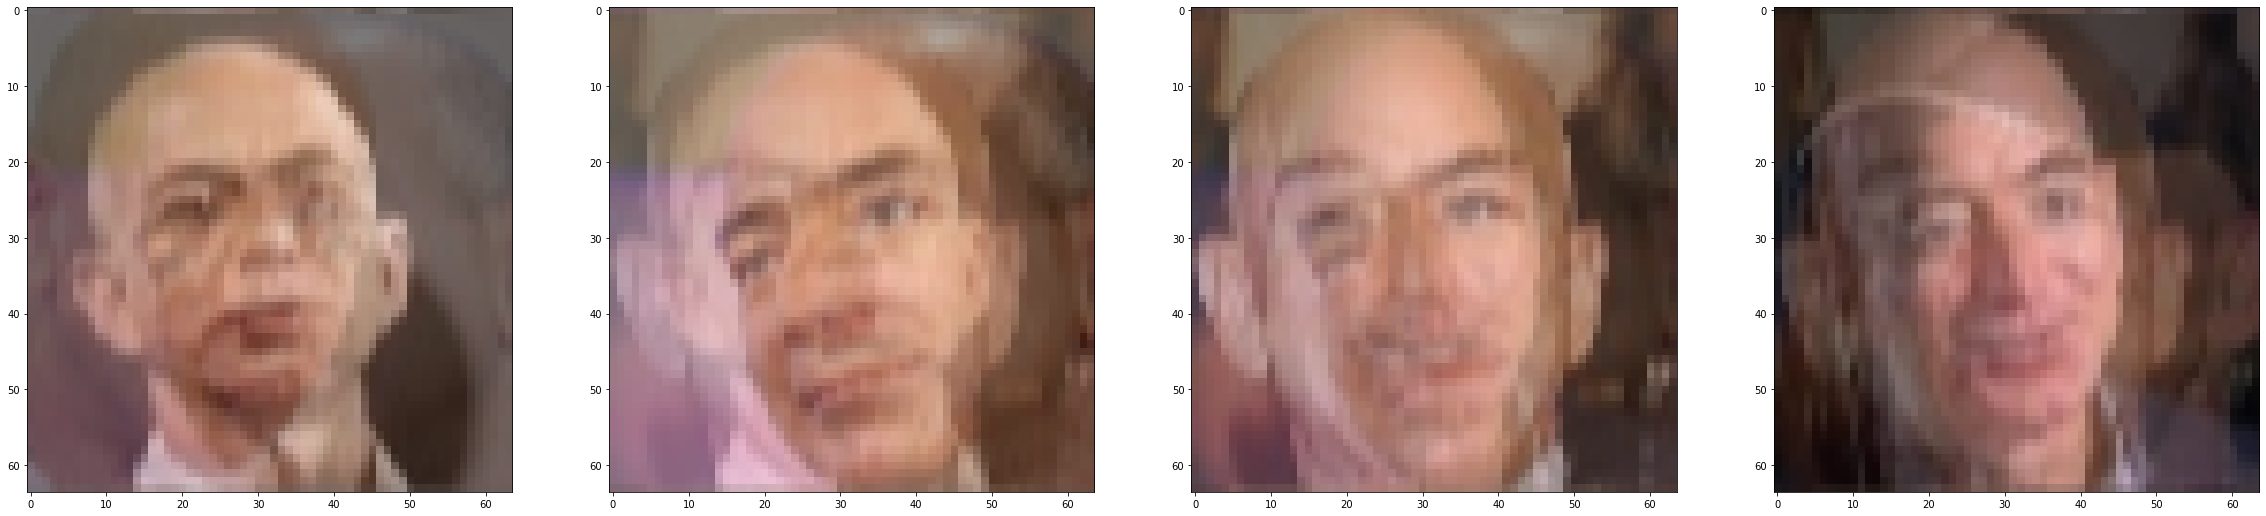

In [8]:
show_img(blurred_dataset)

# Visualzing the original image

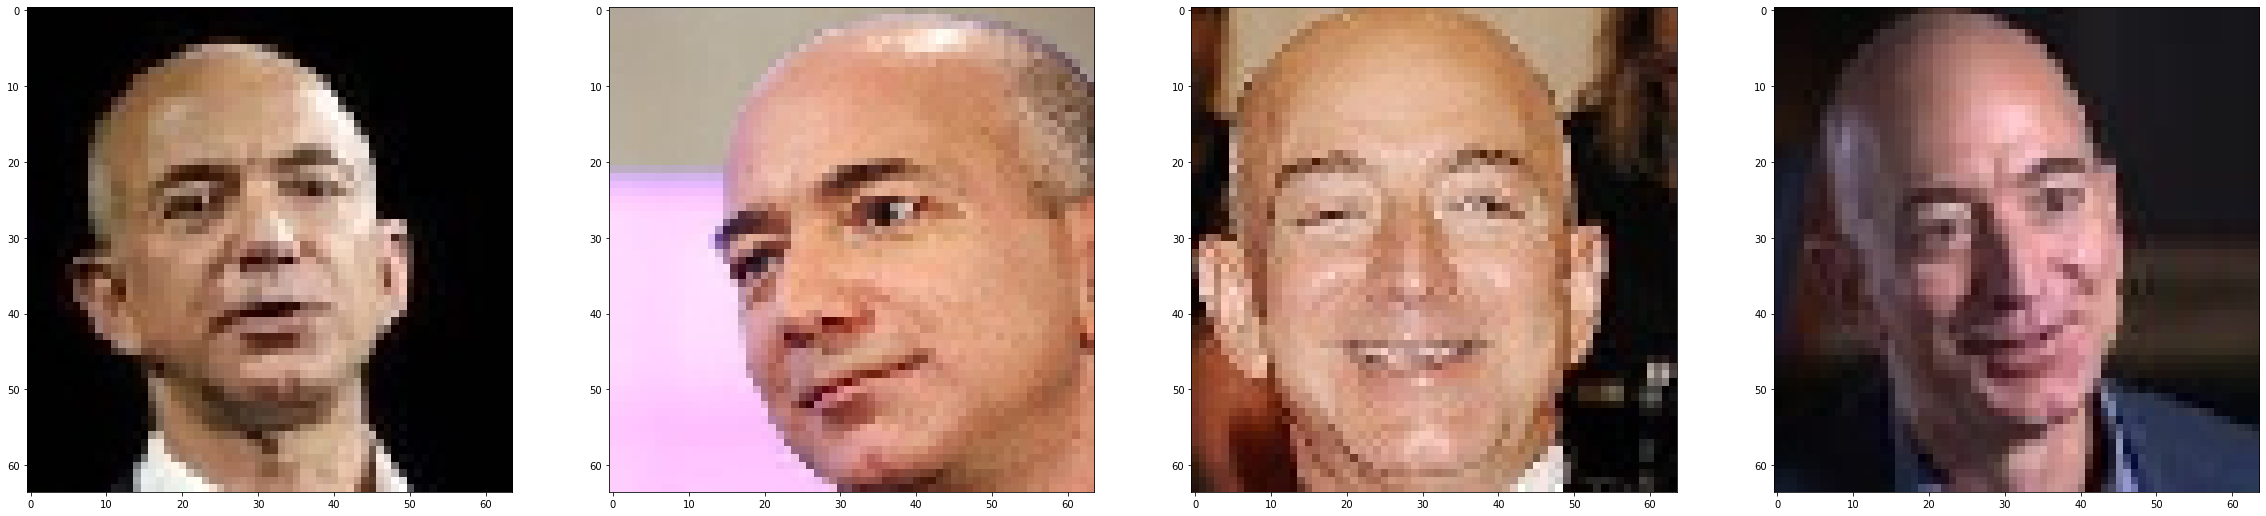

In [9]:
show_img(training_set)

In [10]:
training_set.shape
blurred_dataset.shape

(106, 64, 64, 3)

# Splitting noisy images into train and test data

In [11]:
xtrainnoisy=blurred_dataset[0:100]
xtestnoisy=blurred_dataset[50:100]

In [12]:
train = training_set[0:100]

In [13]:
test = training_set[0:50]

In [14]:
test.shape


(50, 64, 64, 3)

In [15]:
xtestnoisy.shape

(50, 64, 64, 3)

# Training the Autoencoder

In [16]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Input

def autoencoder():
    
    input_img = Input(shape=(64,64,3), name='input_image')
    
 #enoder 
    x = Conv2D(1024, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(1024, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    x = Conv2D(1024, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool3')(x) 
    
    #decoder
    x = Conv2D(1024, (3,3), activation='relu', padding='same', name='Conv7')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(1024, (3,3), activation='relu', padding='same', name='Conv8')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv9')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)

    x = Conv2D(3, (3,3), activation='sigmoid', padding='same', name='Conv13')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [17]:
model= autoencoder()
model.summary()

2021-09-25 05:03:15.584844: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-25 05:03:15.587981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-25 05:03:15.624758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-25 05:03:15.625388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-25 05:03:15.625436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-25 05:03:15.651118: I tensorflow/stream_executor/platform/def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 1024)      28672     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 1024)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 1024)      9438208   
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 1024)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 1024)      9438208   
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 8, 8, 1024)        0     

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
model.fit(train, xtrainnoisy, epochs=100, batch_size=10, validation_data=(test, xtestnoisy), callbacks=[early_stopping])

Epoch 1/100


2021-09-25 05:03:17.643773: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-25 05:03:17.653814: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz
2021-09-25 05:03:18.388169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-25 05:03:23.560189: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-25 05:03:24.277556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


10/10 [==============================] - 10s 161ms/step - loss: 0.0640 - val_loss: 0.0293
Epoch 2/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0302 - val_loss: 0.0279
Epoch 3/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0236 - val_loss: 0.0269
Epoch 4/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0198 - val_loss: 0.0259
Epoch 5/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0167 - val_loss: 0.0271
Epoch 6/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0145 - val_loss: 0.0327
Epoch 7/100
10/10 [==============================] - 1s 114ms/step - loss: 0.0168 - val_loss: 0.0306
Epoch 8/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0151 - val_loss: 0.0288
Epoch 9/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0142 - val_loss: 0.0300
Epoch 10/100
10/10 [==============================] - 1s 111ms/step - loss: 0.0140 - val_loss: 0.0320


# Predictions

In [19]:
import cv2
pred=model.predict(xtestnoisy[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(3, 5)
    f.set_size_inches(11.5,9.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(training_set[i], (64,64,3)), aspect='auto')
        ax[1][i].imshow(np.reshape(xtestnoisy[i], (64,64,3)), aspect='auto')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64,3)), aspect='auto')
        
        

**Original, Noisy and Predicted image respectively**

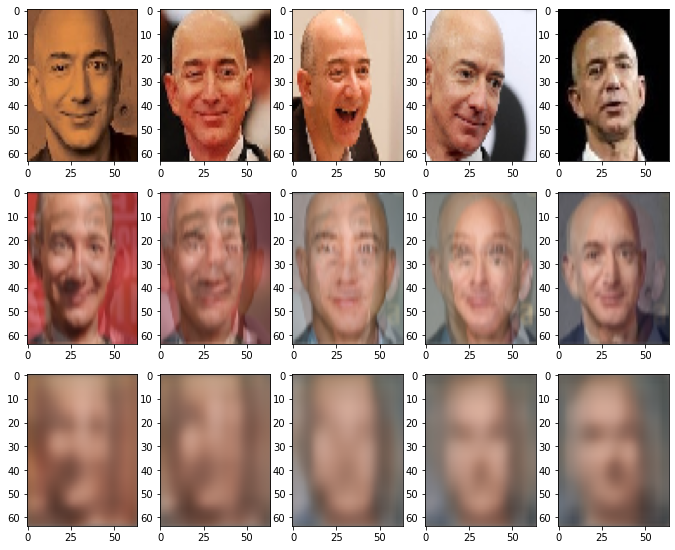

In [20]:
plot_predictions(xtestnoisy[0:5], pred[0:5])

# Comparing original, blurred and the predicted image, it is apparent that a huge amount of blur has been removed in the predicted image. Hence our model has learnt important features of the image and has reconstructed the orginal image from the blurry image by removing the noise. The reconstruction loss is around 0.0370